# Confusion matrix
***

**Author**: Chus Casado Rodríguez<br>
**Date**: 16-02-2024<br>


**Introduction**:<br>
This notebooks computes the hits (true positives, $TP$), misses (false negatives, $FN$) and false alarms (false positives, $FP$) for all the reporting points exceeding a minimum catchment area and the complete study period.

The input data are the time series of probability of exceedance over a discharge threshold both for the reanalysis ("observed") and the forecast.

The confusion matrix ($TP$, $FN$, $FP$) is computed for all the possible combinations of two notificatin criteria: persistence and probability threshold. The values of these two criteria to be tested are defined by the user in the configuration file:
* `hits>criteria>persistence`: is a list of the persistence values to be tested
* `hits>criteria>probability`: is a tuple that defines the probability values to be tested by defining minimum, maximun and the step.

This notebook can be run under two different experiments (`hits>experiment` in the configuration file):

* **NWP** computes the hits individually for each of the four Numerical Weather Prediction (NWP) models used in EFAS.
* **COMB** computes the hits for different combinations of the four NWP above:
    * *1_deterministic_+_1_probabilistic*: one of the deterministic and one of the probabilistic models must detect the event.
    * *model_mean*: a total probability matrix is computed as a simple mean over models.
    * *member_weighted*: the total probability matrix is the weighted mean of the models, where each model gets a weight relative to the number of member it contains.
    * *brier_weighted*: the total probability matrix is the weighted mean of the models, where each model gets a weight relative to its probabilistic skill, measured in terms of Brier score.

In any case, the result is a new set of NetCDF files (one for station) that contains matrixes of hits, misses and false alarms for every combination of the criteria.

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
path_root = os.getcwd()
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator
from datetime import datetime, timedelta
from tqdm import tqdm_notebook
import yaml
import warnings
from pathlib import Path
warnings.filterwarnings("ignore")

os.chdir('../py/')
from config import Config
from compute import *
from seasonal import disaggregate_by_season
from convert import reshape_DataArray, dict2da
from plot.results import plot_weights, plot_brier_skill
from plot.maps import create_cmap, map_events, combine_cmaps
os.chdir(path_root)

## 1 Configuration

In [2]:
config_path = Path('../conf')
config = Config.load_from_yaml(config_path / 'config_leadtime_ranges-test.yml')

### 1.1 Reporting points

In [3]:
# area threshold
area_threshold = config.reporting_points['area']

# fixed notification criteria for the optimization process
area_optimization = config.skill['area']

# reporting points
path_stations = config.reporting_points['output']
file_stations = path_stations / f'reporting_points_over_{area_threshold}km2.parquet'

# rivers
rivers_shp = config.reporting_points['rivers']
if rivers_shp is not None:
    rivers = gpd.read_file(rivers_shp)

### 1.2 Exceedance

In [4]:
# type of experiment: individual models (NWP) or combined (COMB)
exp = config.confusion_matrix['experiment']

# return period
rp = config.discharge['return_period']['threshold']

# path where results from the preprocessing steps were saved
path_reanalysis = config.exceedance['output']['reanalysis'] / f'{rp}'
path_forecast = config.exceedance['output']['forecast'] / f'{rp}'

### 1.3 Confusion matrix

In [5]:
# probability thresholds
probability_range = config.confusion_matrix['criteria']['probability']
probability = np.arange(*probability_range).round(3)
probability = xr.DataArray(probability, dims=['probability'], coords={'probability': probability})

# persistence
persistence = config.confusion_matrix['criteria']['persistence']
persistence = {'/'.join([str(i) for i in pers]): pers for pers in persistence}

# lead time ranges
leadtime = config.confusion_matrix['leadtime']

# parameters of the rolling window used to compute hits
window = config.confusion_matrix['window']
center = config.confusion_matrix['center']

# path where the dataset of hits, misses and false alarms will be saved
path_out_root = config.confusion_matrix['output']
path_out_root = path_out_root / f'{rp}'
if leadtime is None:
    time_agg = 'all_leadtimes'
elif len(leadtime) == 10:
    time_agg = 'daily'
elif len(leadtime) == 20:
    time_agg = '12h'
else:
    time_agg = '_'.join([str(lt + 12) for lt in leadtime])
path_out = path_out_root / f'{exp}' / f'{time_agg}'
path_out.mkdir(parents=True, exist_ok=True)
if exp == 'COMB':
    path_weights = path_out_root / f'{exp}' / 'weighing'
    path_weights.mkdir(parents=True, exist_ok=True)

## 2 Data

### 2.1 Reporting points

I load all the stations that where selected in a previous [notebook](3_0_select_stations.ipynb).

In [6]:
# load table of fixed reporing points
stations = pd.read_parquet(file_stations)

### 2.2 Exceedance reanalysis

In [7]:
# load probability of exceeding the discharge threshold in the REANALYSIS data
rean_exc = xr.open_mfdataset(f'{path_reanalysis}/*.nc', combine='nested', concat_dim='id')['exceedance']
rean_exc = rean_exc.sel(id=stations.index).compute()

print(rean_exc.dims)
print(rean_exc.shape)

('id', 'datetime')
(2371, 3919)


### 2.3 Exceedance forecast

In [8]:
# load probability of exceeding the discharge threshold in the FORECAST data
fore_exc = xr.open_mfdataset(f'{path_forecast}/*.nc', combine='nested', concat_dim='id')
fore_exc['id'] = fore_exc.id.astype(int)
fore_exc = fore_exc.sel(id=stations.index)

# reshape the DataArray of forecasted exceedance
fore_exc = xr.Dataset({label: reshape_DataArray(da, trim=True) for label, da in fore_exc.items()})
fore_exc = fore_exc.transpose('id', 'datetime', 'leadtime', 'model')

# extract starting and ending dates
if ('start' not in locals()) or ('end' not in locals()):
    start = pd.to_datetime(max(rean_exc.datetime.min().data, fore_exc.datetime.min().data))
    end = pd.to_datetime(min(rean_exc.datetime.max().data, fore_exc.datetime.max().data))
else:
    start = max(start, rean_exc.datetime.min(), fore_exc.datetime.min())
    end = min(end, rean_exc.datetime.max(), fore_exc.datetime.max())

# recalculate the exceedance datasets to convert the 3 classes (>Q5, >0.95·Q5, <0.95·Q5) to only 2 (exceedance, non-exceedance)
rean_exc, fore_exc = recompute_exceedance(rean_exc.sel(datetime=slice(start, end)),
                                          fore_exc['high'].sel(datetime=slice(start, end)),
                                          fore_exc['low'].sel(datetime=slice(start, end)))

### 2.4 Weighting factors

**Brier weighting**

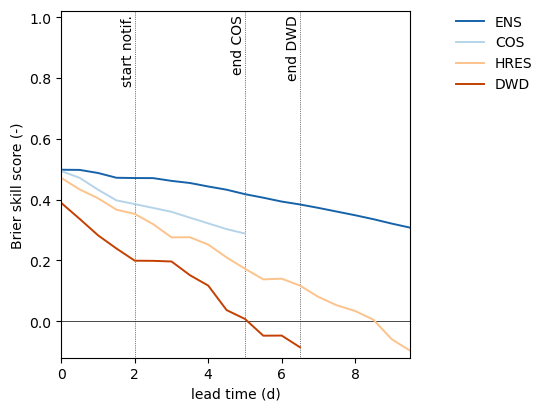

In [9]:
if exp == 'COMB':
    
    # compute Brier scores
    brier = {}
    for model in fore_exc.model.data:
        # extract model forecast
        pred =  fore_exc.sel(model=model).dropna('leadtime', how='any').transpose()
        # squared error
        se = (pred - rean_exc)**2
        # Brier score
        brier[model] = se.mean(['id', 'datetime'])

    # convert dictionary to DatArray
    brier = dict2da(brier, dim='model')

    # CONVERT BRIER SCORE INTO WEIGHTING FACTORS
    # e = 1e-5
    # weights_brier = (brier.max() + e - brier) / (brier.max() + e - (brier.min() - e))
    w = 7
    weights_brier = brier**-w
    weights_brier /= weights_brier.sum('model')

    # export
    brier.to_netcdf(path_weights / 'brier_scores.nc')
    weights_brier.to_netcdf(path_weights / 'weights_brier.nc')

    # climatology
    Pclim = 0
    se= (Pclim - rean_exc)**2
    brier_clim = se.mean(['id', 'datetime'])

    # Brier skill score
    BSS = (brier_clim - brier) / brier_clim

    # create a copy of 'skill_opt' to change acronyms
    ds = BSS.copy()
    ds['model'] = ds['model'].where(ds['model'] != 'EUD', 'HRES')
    ds['model'] = ds['model'].where(ds['model'] != 'EUE', 'ENS')
    ds = ds.reindex(model=['ENS', 'COS', 'HRES', 'DWD'])

    # plot the Brier skill score
    BurOr = combine_cmaps('Blues_r', 'Oranges', .2, .05, name='models')
    df = plot_brier_skill(ds,
                          cmap=BurOr,
                          ylim=(-.12, 1.02),
                          save=path_weights / 'Brier_skill_score.pdf')

>***Figure 1**. Brier skill score for every meteorological model and lead time. The benchmark is a model whose probability of exceedance is 0.*

**Member weighting**

In [10]:
if exp == 'COMB':

    # compute weights by number of members
    weights_member = weights_brier.copy()
    for model in models:
        weights_member.loc[{'model': model}] = weights_member.sel(model=model).where(weights_brier.sel(model=model).isnull(), models[model]['members'])
    weights_member /= weights_member.sum('model')

    # export
    weights_member.to_netcdf(path_weights / 'weights_member.nc')

**Model mean**

In [11]:
if exp == 'COMB':
    # compute weights by number of members
    weights_mean = weights_brier.copy()
    weights_mean = weights_mean.where(weights_mean.isnull(), other=1)
    weights_mean /= weights_mean.sum('model')

    # export
    weights_mean.to_netcdf(path_weights / 'weights_mean.nc')

**Compare weighing methods**

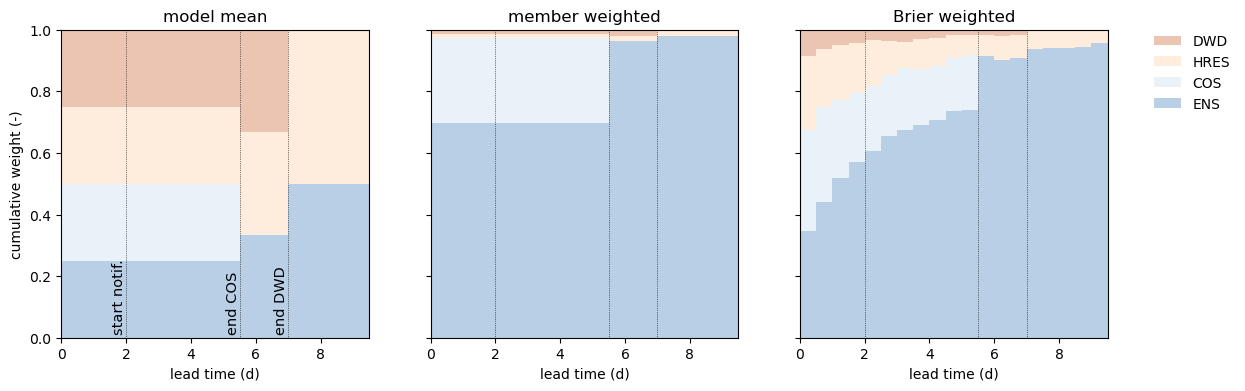

In [12]:
if exp == 'COMB':
    # heatmap of weights
    Weights = xr.Dataset({'model mean': weights_mean, 'member weighted': weights_member, 'Brier weighted': weights_brier})
    Weights['model'] = Weights['model'].where(Weights['model'] != 'EUD', 'HRES')
    Weights['model'] = Weights['model'].where(Weights['model'] != 'EUE', 'ENS')
    Weights = Weights.reindex(model=['ENS', 'COS', 'HRES', 'DWD'])

    plot_weights(Weights,
                 cmap=BurOr,
                 offset=-12,
                 save=path_weights / 'weights.pdf')

>***Figure 2**. Weights assigned to each NWP model and lead time in the three total probability approaches.*

## 3 Analysis

### 3.1 Observed events
#### 3.1.1 Number of events

No. stations with observed events:	494
No. observed events:			660


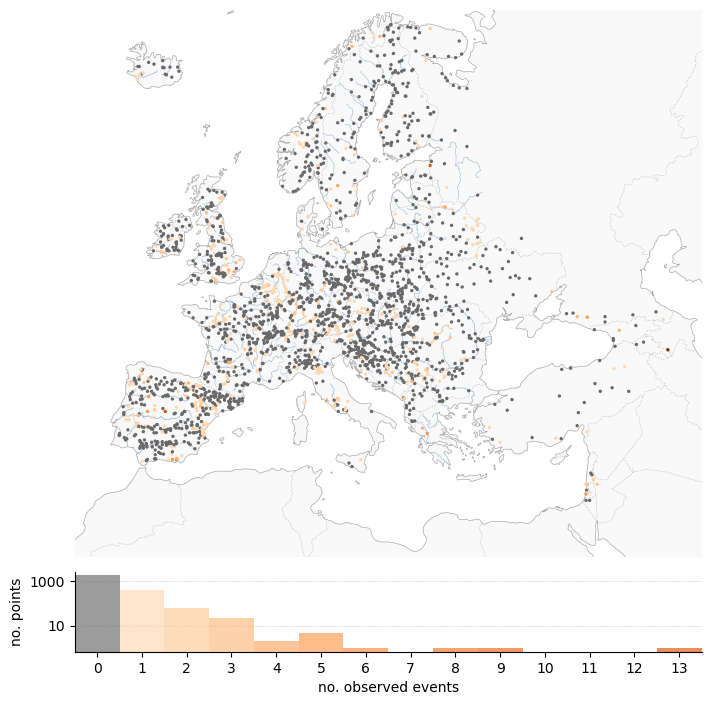

In [13]:
# find the onset of the events
onsets =  xr.concat((rean_exc.isel(datetime=0).astype(bool), rean_exc.diff('datetime')), dim='datetime') == 1
onsets = onsets.sel(datetime=slice(start, end))

# find the offset of the events
offsets = xr.concat((rean_exc.isel(datetime=0).astype(bool), rean_exc.diff('datetime')), dim='datetime') == -1
offsets = offsets.sel(datetime=slice(start, end))

# count number of events
col_events = f'obs_events_{rp}'
stations[col_events] = onsets.sum('datetime').to_pandas()

print('No. stations with observed events:\t{0}'.format((stations[col_events] > 0).sum()))
print('No. observed events:\t\t\t{0}'.format(stations[col_events].sum()))

# export the stations table
stations.to_parquet(file_stations)

# map of the number of events
map_events(stations.X,
           stations.Y, 
           stations[col_events],
           rivers=rivers,
           yscale='log', 
           alpha=1,
           save=path_out_root / f'map_observed_events_{stations.shape[0]}points.jpg')

> ***Figure 3**. Number of observed flood events during the study period.*

The geographical distribution of events is not even. There is a higher proportion of stations with events in Central Europe, British Isles and the Mediterranean catchments than in Estearn and North-Eastern Europe. During the study period there were major events in the Rhine, Meuse and Ebro, which can be seen in the map.

The reporting points with more than 5 flood events during the study period were removed, since it is suspicious that the 5-year return period was exceeded so many times in only 2 years of study period.

#### 3.1.2 Duration of the events

In [14]:
# evaluate the duration (in hours) of each event
event_durations = {}
for stn in tqdm_notebook(onsets.id.data):
    if stations.loc[stn, col_events] == 0:
        continue
    # dates of the onsets and offsets of the events
    dates_onsets = onsets.sel(id=stn).where(onsets.sel(id=stn), drop=True).datetime.data
    dates_offsets = offsets.sel(id=stn).where(offsets.sel(id=stn), drop=True).datetime.data
    # corrections in case the amount of onsets and onsets don't match
    if len(dates_onsets) > len(dates_offsets):
        dates_offsets = np.append(dates_offsets, offsets.datetime[-1].data)
    elif len(dates_onsets) < len(dates_offsets):
        dates_onsets = np.append(onsets.datetime[0].data, dates_onsets)
    # correction in case the first onset is later that the first offset
    else:
        if dates_onsets[0] > dates_offsets[0]:
            print(stn)
            dates_onsets = np.append(onsets.datetime[0].data, dates_onsets)
            dates_offsets = np.append(dates_offsets, offsets.datetime[-1].data)
    # convert into hours
    durations = (dates_offsets - dates_onsets) / np.timedelta64(1, 'h')
    event_durations[stn] = durations

  0%|          | 0/2371 [00:00<?, ?it/s]

In [15]:
# convert dictionary of durations into a flattened array
durations_all, durations_opt = [], []
for stn, arr in event_durations.items():
    for d in arr:
        durations_all.append(d)
        if stations.loc[stn, 'area'] >= area_optimization:
            durations_opt.append(d)
durations_all = np.array(durations_all)
durations_opt = np.array(durations_opt)

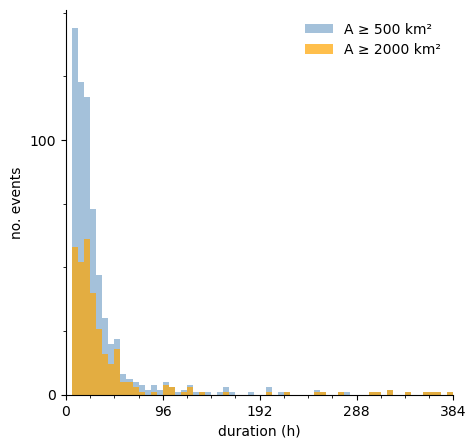

In [16]:
# plot distribution of event duration
alpha = .7
xmin = 0
xmax = 16 * 24
bins = np.arange(xmin, xmax + 1, 6).astype(int)

fig, ax = plt.subplots(figsize=(5, 5))
sns.histplot(durations_all, ax=ax, alpha=alpha**2, bins=bins, color='steelblue', edgecolor=None, label=f'A ≥ {area_threshold} km²')
sns.histplot(durations_opt, ax=ax, alpha=alpha, bins=bins, color='orange', edgecolor=None, label=f'A ≥ {area_optimization} km²')
ax.set(xlabel='duration (h)', ylabel='no. events', xlim=(xmin, xmax));
ax.spines[['right', 'top']].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(96))
ax.xaxis.set_minor_locator(MultipleLocator(24))
ax.yaxis.set_major_locator(MultipleLocator(100))
ax.yaxis.set_minor_locator(MultipleLocator(25))
ax.legend(frameon=False);

plt.savefig(path_out_root / f'duration_distribution_{stations.shape[0]}points.jpg',
            dpi=300, bbox_inches='tight')

>***Figure 4**. Distributions of the duration of the observed flood events. In blue the events observed in points with a catchment area of at least `area_threshold` km², in orange those that exceed `area_optimization` km².*

### 3.2 Hits, misses and false alarms

In [ ]:
path_netcdf = path_out / f'window_{window}'
path_netcdf.mkdir(parents=True, exist_ok=True)

for stn in tqdm_notebook(stations.index):
    
    # check if the output file already exists
    file_out = path_netcdf / f'{stn:>04}.nc'
    if os.path.exists(file_out):
        continue 
    
    # FORECAST EXCEEDANCE PROBABILITY
    
    if exp == 'COMB':
        
        forecast = fore_exc.sel(id=stn)

        # TOTAL PROBABILITY OF EXCEEDANCE

        # exceedance according to 1 deterministic + 1 probabilistic
        deterministic = (forecast.sel(model=['EUD', 'DWD']) >= probability).any('model')
        probabilistic = (forecast.sel(model=['EUE', 'COS']) >= probability).any('model')
        deterministic_probabilistic = deterministic & probabilistic

        # exceedance according to mean over models
        model_mean = forecast.mean('model', skipna=True) >= probability

        # exceedance according to the mean over models weighted by the number of members
        member_weighted = forecast.weighted(weights_member.fillna(0)).mean('model', skipna=True) >= probability

        # exceedance according to the mean over models weighted by the inverse Brier score
        brier_weighted = forecast.weighted(weights_brier.fillna(0)).mean('model', skipna=True) >= probability

        # merge all total probability approaches in a single DataArray
        total_exc = xr.Dataset({
                                '1_deterministic_+_1_probabilistic': deterministic_probabilistic,
                                'model_mean': model_mean,
                                'member_weighted': member_weighted,
                                'brier_weighted': brier_weighted,
                                }).to_array(dim='model')

        del forecast
    
    # HITS, MISSES, FALSE ALARMS
    
    hits = {}
    for label, pers in persistence.items():
        
        # compute predicted events
        if exp == 'NWP':
            pred = exceedance2events(fore_exc.sel(id=stn), probability, persistence=pers, leadtime=leadtime)
        elif exp == 'COMB':
            pred = exceedance2events(total_exc, persistence=pers, leadtime=leadtime)

        # compute hits, misses and false alarms
        hits[label] = events2hits(rean_exc.sel(id=stn), pred, center=center, w=window)
    
    # convert to NaN lead times that can't be reached due to model limitations or persistence
    hits = dict2da(hits, dim='persistence')
    hits = limit_leadtime(hits, exp=exp)
    
    print(f'Exporting file {file_out}', end='\r')
    hits.to_netcdf(file_out)

    del pred, hits

  0%|          | 0/2371 [00:00<?, ?it/s]